<a href="https://colab.research.google.com/github/wajnryt/JerusMLDeepLearning2019/blob/master/InstanceClassifierRachel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# DataSet object
import pandas as pd
import os
from torch.utils.data.dataset import Dataset
import imageio
import numpy as np

def create_instance_hashmap():
      index = 1
      names  = np.unique(dataset.data['instance_id'])
      instanceDict = {}
      for str in names:
        instanceDict[str] = index
        index = index+1
        print (str, index)
        


class InstanceDataset(Dataset):
          
  
    def __init__(self, basedir, transform=None):
        super().__init__()
        files = glob.glob(os.path.join(basedir ,'*','*','*.jpg'))
        self.data = pd.DataFrame([self._split_file(f) for f in files], 
                            columns=['instance_id', 'file_path'])
        index = 0
        names  = np.unique(self.data['instance_id'])
        self.instanceDict = {}
        for str in names:
          self.instanceDict[str] = index
          index = index+1
          
        self.data['instance_num'] = self.data['instance_id'].map(self.instanceDict)
          
    
        
    def _split_file(self, f):
        parts = f.split(os.sep)[-3:-1]
        return parts[1], f   #label is originaly a str

    def __getitem__(self, index):
      dat = self.data.iloc[index]
      img = imageio.imread(dat['file_path'])
      img = np.resize(img,(3,128,128))
      return (torch.from_numpy(img.astype(np.float32)), dat['instance_num'])
    
    def __len__(self):
        return len(self.data)
          
        



In [0]:
import glob
import torchvision.transforms as transforms

basedir = '/content/gdrive/My Drive/videos_2/yt_bb_detection_train'       
        
dataset = InstanceDataset(basedir)   

In [0]:
len((dataset.data['instance_num']))
len(np.unique(dataset.data['instance_num']))
dataset.data['instance_num'][200]
max(np.unique(dataset.data['instance_num']))

In [0]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

#Divide data to train/test
dataset = InstanceDataset(basedir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])


batch_size = 50

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('Train size: {}'.format(len(train_loader)))


Train size: 1585


In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv3 = nn.Conv2d(50,60,6,1)
        self.fc1 = nn.Linear(34560, 10000)
        self.fc2 = nn.Linear(10000, 6476)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 34560)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

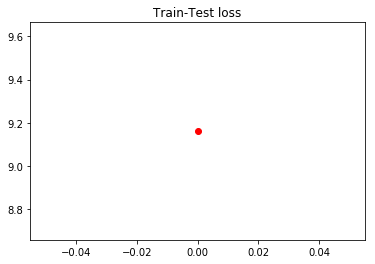

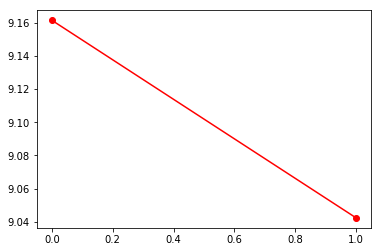

In [0]:
import torch
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

use_cuda = torch.cuda.is_available()

import time
tf = time.time()  

#model = LeNet()
model = models.resnet18(pretrained=True)

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

if use_cuda:
   model = model.cuda()
    
num_final_in = model.fc.in_features

NUM_CLASSES = len(np.unique(dataset.data['instance_num']))
model.fc = nn.Linear(num_final_in, NUM_CLASSES)    
    
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

criterion = nn.CrossEntropyLoss()
predicts=[]
trainloss = []
testloss = []

import matplotlib.pyplot as plt
import pylab as pl

fig = plt.figure(1)
plt.title('Train-Test loss')

for epoch in range(10):
    # trainning
    ave_loss = 0

    for batch_idx, (x, target) in enumerate(train_loader):
#         print (x.shape)
#         print (target)
        optimizer.zero_grad()
        if use_cuda:
            print(x.shape)
            x, target = x.cuda(), target.cuda()
        
        out = model(x)
#         print(len(out))
#         print(len(target))
        loss = criterion(out, target) 
        
        #print(f'loss: {loss}')
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))    
            
        trainloss.append(loss.data)
        writer.add_text('train loss: ', loss.data)
#         pl.figure(1)
#         train_handle, = plt.plot(trainloss, 'ro-')
#         pl.show()

    
     # testing    
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x = x.float()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        #x, target = Variable(x, volatile=True), Variable(target, volatile=True)
        out = model(x)   
#         print(out)

        loss = criterion(out, target)
        
        _, pred_label = torch.max(out.data, 1)
        predicts.append(pred_label)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss,float(correct_cnt)/total_cnt))
          
        testloss.append(loss.data) 
        writer.add_text('test loss: ', loss.data)
#         pl.figure(1)
#         test_handle, = plt.plot(testloss, 'bo-')
#         pl.show()

torch.save(model.state_dict(), model.name())
writer.close()

elapsed = time.time() - tf
      